# Introducción al análisis técnico con Binance API

Este cuaderno introduce el uso de Binance API para obtener precios de activos, y el cómputo de indicadores de análisis técnico.

**Contenido**

1. Uso básico de cliente [python-binance](https://python-binance.readthedocs.io).
    - Consulta de precios de activos.
    - Descarga de series temporales con datos históricos.
2. Visualización de gráficos de velas con [Matplotlib Finance](https://github.com/matplotlib/mplfinance).
3. Obtención y visualización de algunos indicadores de análisis técnico con [Technical Analysis Library in Python](https://github.com/bukosabino/ta).

**Recursos y enlaces de interés**

- [TA-Lib - Python Technical Analysis Library](https://github.com/mrjbq7/ta-lib)
- [API Dólar Argentina](https://github.com/Castrogiovanni20/api-dolar-argentina): API REST en Heroku con cotización de dólar oficial, blue, etc..

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from datetime import datetime, timedelta,timezone
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Conexión con cliente binance

In [3]:
#!pip install --upgrade python-binance dateparser mplfinance
!pip list | grep python-binance

python-binance                     1.0.16


In [4]:
import json
import os

assert os.path.exists("secrets.json"), "Se debe proveer un archivo JSON con los parámetros de conexión a la API de Binance"
with open("secrets.json","r") as fp:
    secrets = json.load(fp)

In [5]:
import binance
from binance import Client

client = Client(secrets["binance"]["api_key"], secrets["binance"]["secret_key"])

Obtener status del servidor.

In [6]:
status = client.get_system_status()
status

{'status': 0, 'msg': 'normal'}

Obtener timestamp de server (ms).

In [7]:
time_res = client.get_server_time()
time_res

{'serverTime': 1656885995335}

Aparentemente todas las consultas a la API y operaciones se hacen con tiempo UTC, que se provee como un texto ISO. Por lo tanto, recordar hacer las conversiones para representar con hora local (+- 3).

In [8]:
server_datetime_utc = pd.to_datetime(time_res['serverTime'], unit='ms', utc=True)
server_datetime_utc

Timestamp('2022-07-03 22:06:35.335000+0000', tz='UTC')

Nota. Esto se puede manejar mejor desde Python con TZ, ver después.

In [9]:
server_datetime_arg = server_datetime_utc - pd.Timedelta(hours=3)
server_datetime_arg

Timestamp('2022-07-03 19:06:35.335000+0000', tz='UTC')

## Consulta de activos y precios

Obtener lista de precios de todos los activos.

- `bidPrice`: precio de venta.
- `askPrice`: precio de compra.
- `bidQty`: volumen de oferta? Unidad?
- `askQty`: volumen de demanda? Unidad?

In [10]:
tickers = client.get_orderbook_tickers()
df_tickers = pd.DataFrame(tickers)
df_tickers.head()

,symbol,bidPrice,bidQty,askPrice,askQty
0,ETHBTC,0.05574600,12.27960000,0.05574700,21.81440000
1,LTCBTC,0.00264200,11.76700000,0.00264300,13.54400000
2,BNBBTC,0.01136400,13.37100000,0.01136500,8.61600000
3,NEOBTC,0.00043000,75.52000000,0.00043100,993.71000000
4,QTUMETH,0.00262400,235.40000000,0.00263300,16.80000000


In [11]:
print("Cantidad de activos:",len(df_tickers.symbol.unique()))

Cantidad de activos: 2073


Obtener el precio actual de un activo.

In [12]:
df_tickers[df_tickers.symbol=='BTCUSDT']

,symbol,bidPrice,bidQty,askPrice,askQty
11,BTCUSDT,19294.41000000,4.68663000,19294.42000000,2.80360000


Opcional: convertir a AR$ con la cotización actual del dólar oficial, utilizando el precio de venta.

In [13]:
import requests
usdt_in_ars_sell_price = float(requests.get("https://api-dolar-argentina.herokuapp.com/api/dolaroficial").json()['venta'])
usdt_in_ars_sell_price

129.99

In [14]:
btc_price_usd = float(df_tickers[df_tickers.symbol=='BTCUSDT'].askPrice)
btc_price_usd

19294.42

In [15]:
print("Precio actual aproximado del BTC en AR$: {:,.3f}".format(btc_price_usd*usdt_in_ars_sell_price))

Precio actual aproximado del BTC en AR$: 2,508,081.656


## Análisis de datos históricos

Se pueden descargar las series temporales con datos históricos de un activo para generar un [gráfico OHLCV](https://www.investopedia.com/terms/o/ohlcchart.asp#:~:text=An%20OHLC%20chart%20shows%20the,structure%20is%20called%20a%20bar) (acrónimo de *Open, High, Low, Close, Volume*). 

Un gráfico OHLCV es un tipo de gráfico que contiene:

- **Open**: precio del activo en el momento de apertura. En el caso de BTC/USDT, se toma el precio en U$S.
- **Close**: precio del activo en el momento de cierre. Para muchos traders, este es el indicador más relevante.
- **High**: precio máximo que tomó el activo.
- **Low**: precio mínimo que tomó el activo.
- **Volume**: volumen de operaciones. ¿Cómo se obtiene? ¿Es el número de órdenes por el monto promedio de cada una?

### Consulta y descarga de datos

Parámetros:

- `SYMBOL`: nombre del activo.
- `INTERVAL`: intervalo entre muestras: minuto, hora o diario.
- `start_date`: fecha y hora inicial en formato ISO.
- `end_date`: fecha y hora final en formato ISO. Si se omite se usa la actual.

**Nota**: el máximo de muestras que retorna binance es 1000. Aparentemente no hace una agregación automática, por lo que si se solicita un intervalo entre muestras muy chico y ventana muy grande, la serie obtenida puede estar incompleta.

In [16]:
# Ejemplo: tomar como inicio el 2022-06-30 a las 22hs  hora argentina.
start_date = datetime.fromisoformat("2022-06-30T22:00:00") + timedelta(hours=3) # El +3 es para convertir a UTC 
end_date = start_date + timedelta(days=3)
start_date, end_date

(datetime.datetime(2022, 7, 1, 1, 0), datetime.datetime(2022, 7, 4, 1, 0))

In [17]:
from binance.enums import HistoricalKlinesType

SYMBOL = 'BTCUSDT'
INTERVAL = Client.KLINE_INTERVAL_1HOUR
#INTERVAL = Client.KLINE_INTERVAL_1MINUTE
#INTERVAL = Client.KLINE_INTERVAL_1DAY

klines = client.get_historical_klines( 
    symbol=SYMBOL, 
    interval=INTERVAL, #
    start_str=start_date.isoformat(),
    end_str=end_date.isoformat(),
    #end_str=None,
    limit=1000,
    klines_type=HistoricalKlinesType.SPOT
)

### Interpretación de los datos

Las series devueltas por la API de Binance contienen:

- `open_time`: tiempo de apertura en UTC con precisión de milisegundos.
- `close_time`: las criptomonedas no tienen un horario de mercado como otros instrumentos tradicionales -por ejemplo, de lunes a viernes de 9:30AM a 16:00PM-, por lo tanto en las series devueltas `close_time` siempre será igual a `open_time` + `INTERVAL`.
- `open`: precio en apertura. En el caso de BTCUSDT, en U$S.
- `high`: precio más alto.
- `low`: precio más bajo. 
- `close`: precio al cierre. 
- `volume`: volumen, pero cómo se calcula?
- `quote_asset_volume`: ???
- `number_of_trades`: cantidad total de operaciones en el intervalo? Confirmar.
- `taker_buy_base_asset_volume`: ???
- `taker_buy_quote_asset_volume`: ???
- `ignore`: ???

In [18]:
def binance_klines_to_df(klines):
    columns = [
        'open_time', 
        'open', 
        'high', 
        'low', 
        'close', 
        'volume',
        'close_time', 
        'quote_asset_volume', 
        'number_of_trades',
        'taker_buy_base_asset_volume', 
        'taker_buy_quote_asset_volume',
        'ignore'
    ]

    df = pd.DataFrame(klines, columns=columns)

    # Convert dtypes
    for x in ["open_time","close_time"]:
        df[x] = pd.to_datetime(df[x], unit='ms') - pd.Timedelta(hours=3)
    df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')
    for x in ["open","close","high","low","volume"]:
        df[x] = df[x].astype(float)
    return df
    
df = binance_klines_to_df(klines)
df = df.set_index(pd.DatetimeIndex(df['close_time']))
df.head()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
close_time,,,,,,,,,,,,
2022-06-30 22:59:59.999,2022-06-30 22:00:00,20295.09,20475.15,20260.00,20416.46,5242.15213,2022-06-30 22:59:59.999,106749553.14003930,68071,2744.56553000,55883921.61317300,0
2022-06-30 23:59:59.999,2022-06-30 23:00:00,20416.45,20552.29,20269.95,20300.69,3668.92227,2022-06-30 23:59:59.999,74785021.08165560,53024,1799.37831000,36674297.80266100,0
2022-07-01 00:59:59.999,2022-07-01 00:00:00,20300.68,20309.55,19688.00,19730.76,6570.88765,2022-07-01 00:59:59.999,131602882.28813590,86467,3064.19088000,61353849.43176220,0
2022-07-01 01:59:59.999,2022-07-01 01:00:00,19730.77,19773.71,19366.89,19409.23,7334.11812,2022-07-01 01:59:59.999,143647034.15279790,94313,3588.68876000,70289142.19507180,0
2022-07-01 02:59:59.999,2022-07-01 02:00:00,19409.23,19579.43,19315.91,19465.37,4453.06582,2022-07-01 02:59:59.999,86577116.93445360,57404,2293.43285000,44586334.95989370,0


### Gráfico OHLC o "gráficos de velas"

Tienen origen en el [mercado japonés de arroz en el siglo 18](https://ninjatrader.com/es/blog/candlestick-charting-legend-of-munehisa-homma/). Representan gráficamente la información OHLC.

<img src="https://www.researchgate.net/publication/352017050/figure/fig1/AS:1029759769268225@1622525269849/e-OHLC-candlestick-data-in-chart-and-comma-separated-value-CSV-representations.ppm" />

Cuando se representa la información de precios de esta manera, pueden aparecer patrones asociados a conductas del mercado. Ejemplo:

<img src="https://f.hubspotusercontent10.net/hubfs/20705417/Imported_Blog_Media/CANDLESTICKQUICKGUIDE-Mar-18-2022-09-42-46-01-AM.png"/>

Fuente: https://www.tradingsim.com/

Los patrones están asociados a "estados del mercado". Se suelen usar los términos "bulls market" y "bears market" para indicar una economía creciente o en deterioro, respectivamente.

- **Bulls market**: período sostenido con alza de precios (meses o años). No hay una definición formal, pero a dedo gordo: 20% arriba, 20%, abajo, 20% arriba. 
    - Economía fuerte.
    - Crecimiento de PIB.
    - Incremento de beneficios de compañìas.
    - Bajo desempleo.
    - Aumento de consumo.
- **Bears market**:
    - Economía en deterioro.
    - Baja de PIB.
    - Recorte de compañìas.
    - Aumento de desempleo.

In [19]:
import mplfinance as mpf

In [20]:
def convert_binance_df_to_mpf_df(df):
    """ Matplotlib Finance espera un formato específico de Dataframe. 
    """
    df_converted = df.copy()
    df_converted.rename(
        columns = {
            'close_time': 'Date', 
            'open':'Open', 
            'low':'Low', 
            'high':'High',
            'close':'Close',
            'volume':'Volume' }, inplace = True)    
    df_converted.drop(
        [
            'open_time',
            'quote_asset_volume',
            'number_of_trades',
            'taker_buy_base_asset_volume',
            'taker_buy_quote_asset_volume',
            'ignore'
        ], axis=1,inplace=True)    
    return df_converted

Graficar con Matplotlib Finance.

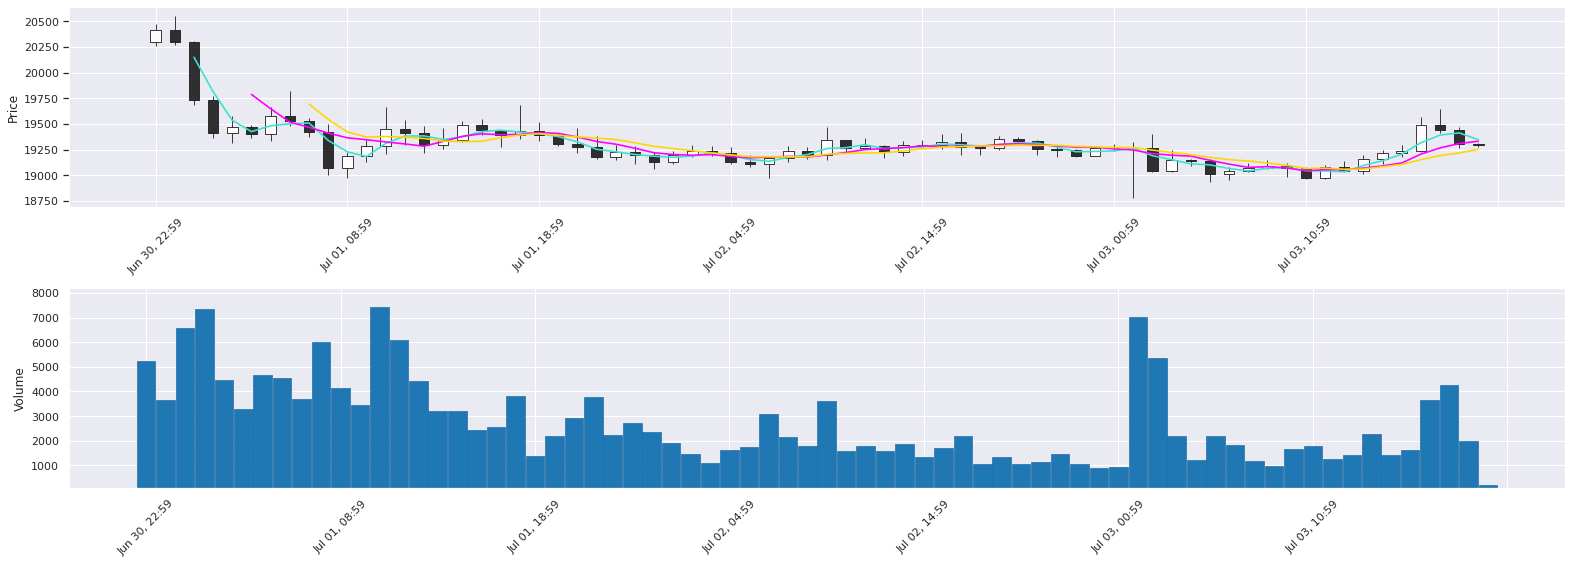

In [21]:
df_converted = convert_binance_df_to_mpf_df(df)
fig,axes = plt.subplots(2,1,figsize=(22,8))
mpf.plot(df_converted,type='candle',mav=(3,6,9),volume=axes[1],ax=axes[0])
#mpf.plot(df,type='line',mav=(3,6,9),volume=axes[1],ax=axes[0])
#axes[0].axvline(x=pd.Timestamp('2022-06-30 22:40:00'))
fig.tight_layout()

## Introducción al análisis técnico

El análisis técnico parte del supuesto de que los movimientos de precios de un activo en el futuro pueden predecirse a partir de movimientos pasados porque el mercado tiene un comportamiento emocional que se refleja en las operaciones de compra y venta. 

Su objetivo es definir indicadores sobre el comportamiento del mercado, que pueden incluir:

- Indicadores de [momento o aceleración](https://www.investopedia.com/terms/m/momentum.asp).
- Indicadores de [volatilidad](https://www.investopedia.com/articles/financial-theory/08/volatility.asp).
- Indicadores de [tendencia](https://www.investopedia.com/terms/t/trendanalysis.asp).
- Indicadores de [volumen](https://www.investopedia.com/terms/v/volumeoftrade.asp).

Por lo general, se usan estos indicadores para decidir si es conveniente realizar una operación de compra, venta, o esperar. 

**Supuestos**:

1. Los precios no son totalmente aleatorios.
2. Los precios actuales y futuros pueden explicarse parcialmente usando información pasada .
3. Existen patrones que se repiten, que son el resultado de conductas de compradores y vendedores, en las que interviene la "psicología del mercado".
    
**Críticas**:

1. Predomina la aleatoreidad en los precios en el corto y mediano plazo (*). Si hay aleatoreidad, no puede haber patrones. Referencias:
    - https://web.williams.edu/Mathematics/sjmiller/public_html/341/handouts/Fama_RandomWalksStockPrices.pdf
    - https://thescipub.com/pdf/jmssp.2010.342.346.pdf
2. El precio actual de un bien es el resultado de una proyección a futuro de su utilidad. Por lo tanto, su valor estimado debe buscarse en el futuro, no en el pasado. Un ejemplo. El precio del Bitcoin depende de lo que se especula que valdrá en el futuro independientemente del valor que haya tenido antes. 
3. Existe un sesgo psicológico a favor de creer que existen patrones en las cosas, y que saber encontrarlos y manipularlos nos dá algún tipo de ventaja competitiva. No importa si las herramientas son [rústicas](https://economics.mit.edu/files/7258) o [modelos de deep learning avanzados](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1174/reports/2748739.pdf), en el fondo, confiamos en que existe una técnica que podemos llegar a utilizar que va a permitir explotar esos patrones.

(*) No así en el largo plazo. Por ejemplo, es altamente probable que un bien o servicio escaso que tenga una demanda sostenida aumente su valor en el tiempo, o un bien o servicio se devalúe por obsolecencia, cambio cultural, etc.

Fuente: https://www.youtube.com/watch?v=egjfIuvy6Uw

### Cómputo y visualización de indicadores con Python Technical Analysis Library

El módulo más completo y utilizado para análisis técnico en Python es [TA-lib](https://github.com/mrjbq7/ta-lib), pero por simplicidad en este caso se utiliza [Python Technical Analysis Library (ta)](https://github.com/bukosabino/ta), que se integra más fácilmente con Pandas. 

In [22]:
#!conda install -c conda-forge ta-lib ta -y

Conversión de un dataframe al formato de Python Technical Analysis Library.

In [23]:
from ta import add_all_ta_features
from ta.utils import dropna

def convert_binance_df_to_ta_df(df):
    df_converted = df.copy()
    df_converted = dropna(df_converted)    
    df_converted=df_converted.reset_index(drop=True)
    df_converted.rename(
        columns={
            "open": "Open",
            "close":"Close",
            "high": "High",
            "low": "Low",
            "close": "Close",
            "volume": "Volume"
        },inplace=True
    )        
    df_converted.drop(
            [
                'open_time',
                'quote_asset_volume',
                'number_of_trades',
                'taker_buy_base_asset_volume',
                'taker_buy_quote_asset_volume',
                'ignore'
            ], axis=1,inplace=True)    
    df_converted['Timestamp'] = df_converted['close_time'].astype(int) / int(1e9)   
    df_converted['Timestamp'] = df_converted['Timestamp'].astype(int)
    #df_converted = df_converted.set_index(pd.RangeIndex(int(df_converted['Timestamp'])))
    #df_converted.drop(["Timestamp"],inplace=True)
    return df_converted

Generación de todos los indicadores.

In [24]:
df_ta = convert_binance_df_to_ta_df(df)
df_ta = add_all_ta_features(df_ta, open="Open", high="High", low="Low", close="Close", volume="Volume")
df_ta.tail()

/home/nhorro/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/home/nhorro/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


,Open,High,Low,Close,Volume,close_time,Timestamp,volume_adi,volume_obv,volume_cmf,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
65,19221.76,19299.00,19182.64,19236.74,1631.47903,2022-07-03 15:59:59.999,1656863999,-22436.482422,-27401.76146,0.035367,...,-0.170935,-0.286270,0.115335,-9.322452,-8.532533,-0.789919,19144.162425,0.077880,0.077850,-5.778279
66,19236.73,19565.05,19224.88,19492.16,3647.04707,2022-07-03 16:59:59.999,1656867599,-20352.378945,-23754.71439,0.090776,...,-0.010645,-0.231145,0.220501,-0.615294,-6.949085,6.333792,19208.780160,1.327772,1.319034,-4.527230
67,19492.15,19647.63,19414.89,19445.43,4265.52263,2022-07-03 17:59:59.999,1656871199,-23498.463050,-28020.23702,0.006211,...,0.095380,-0.165840,0.261220,7.560631,-4.047142,11.607773,19239.756386,-0.239737,-0.240025,-4.756113
68,19445.44,19469.57,19265.00,19300.92,1976.69145,2022-07-03 18:59:59.999,1656874799,-24780.988621,-29996.92847,-0.007471,...,0.117312,-0.109210,0.226522,5.611066,-2.115500,7.726566,19242.414635,-0.743157,-0.745932,-5.463925
69,19300.92,19314.24,19278.00,19294.42,217.28988,2022-07-03 19:59:59.999,1656878399,-24801.374537,-30214.21835,-0.018854,...,0.130447,-0.061278,0.191726,-2.611843,-2.214769,-0.397074,19244.938783,-0.033677,-0.033683,-5.495762


### Indicadores de volatilidad

#### Bandas de Bollinger

Fuente: [Bandas de Bollinger en Wikipedia](https://es.wikipedia.org/wiki/Bandas_de_Bollinger)

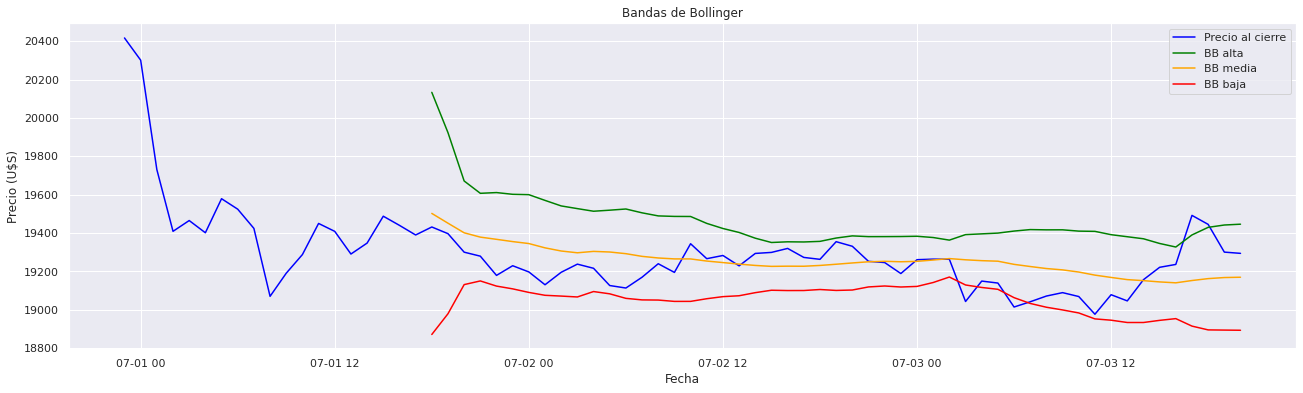

In [25]:
fig,axes = plt.subplots(1,1,figsize=(22,6))
axes.plot(df_ta.close_time, df_ta.Close,color="blue")
axes.plot(df_ta.close_time, df_ta.volatility_bbh,color="green")
axes.plot(df_ta.close_time, df_ta.volatility_bbm,color="orange")
axes.plot(df_ta.close_time, df_ta.volatility_bbl,color="red")
axes.legend(["Precio al cierre", "BB alta", "BB media", "BB baja"])
axes.set_ylabel("Precio (U$S)")
axes.set_xlabel("Fecha")
axes.set_title(f"Bandas de Bollinger");

#### Canal de Keltner

Fuente: [Canal de Keltner en Wikipedia](https://en.wikipedia.org/wiki/Keltner_channel)

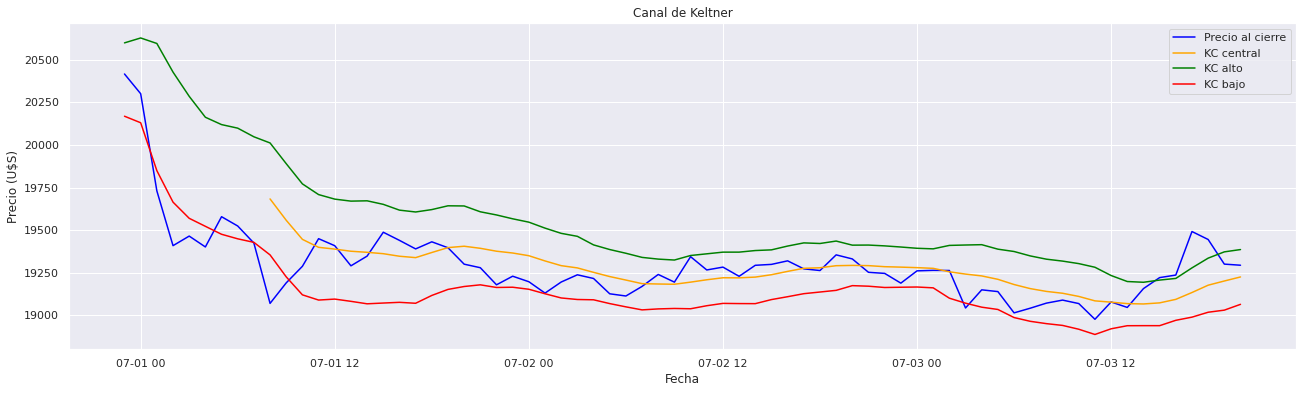

In [26]:
fig,axes = plt.subplots(1,1,figsize=(22,6))
axes.plot(df_ta.close_time, df_ta.Close,color="blue")
axes.plot(df_ta.close_time, df_ta.volatility_kcc,color="orange")
axes.plot(df_ta.close_time, df_ta.volatility_kch,color="green")
axes.plot(df_ta.close_time, df_ta.volatility_kcl,color="red")
axes.legend(["Precio al cierre", "KC central", "KC alto", "KC bajo"])
axes.set_ylabel("Precio (U$S)")
axes.set_xlabel("Fecha")
axes.set_title(f"Canal de Keltner");

#### Canal de Donchian

Fuente: [Canal de Donchian en Wikipedia](https://en.wikipedia.org/wiki/Donchian_channel)

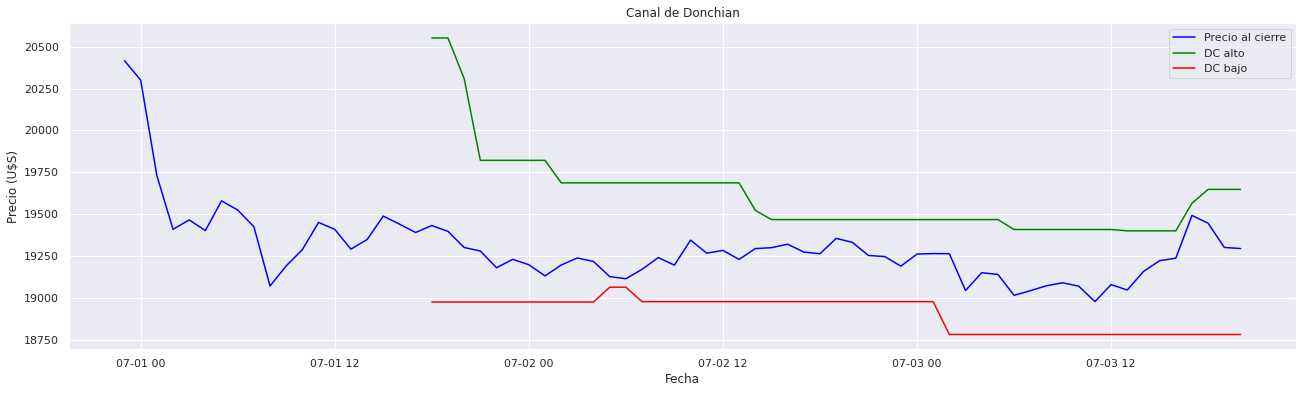

In [27]:
fig,axes = plt.subplots(1,1,figsize=(22,6))
axes.plot(df_ta.close_time, df_ta.Close,color="blue")
axes.plot(df_ta.close_time, df_ta.volatility_dch,color="green")
axes.plot(df_ta.close_time, df_ta.volatility_dcl,color="red")
axes.legend(["Precio al cierre", "DC alto", "DC bajo"])
axes.set_ylabel("Precio (U$S)")
axes.set_xlabel("Fecha")
axes.set_title(f"Canal de Donchian");

### Indicadores de tendencia

#### Indicador de Media Móvil de Convergencia/Divergencia (MACD)


Fuente: [MACD en Wikipedia](https://es.wikipedia.org/wiki/MACD)

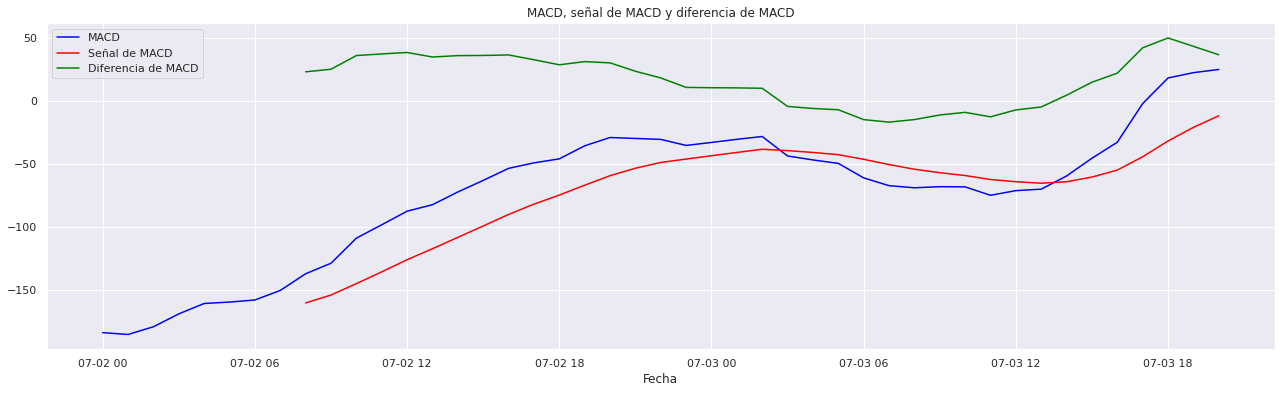

In [28]:
fig,axes = plt.subplots(1,1,figsize=(22,6))
axes.plot(df_ta.close_time, df_ta.trend_macd,color="blue")
axes.plot(df_ta.close_time, df_ta.trend_macd_signal,color="red")
axes.plot(df_ta.close_time, df_ta.trend_macd_diff,color="green")
axes.legend(["MACD", "Señal de MACD", "Diferencia de MACD"])
#axes.set_ylabel("Precio (U$S)")
axes.set_xlabel("Fecha")
axes.set_title(f"MACD, señal de MACD y diferencia de MACD");

#### Oscilador Know Sure Thing (KST)

Fuente: [Oscilador Know Sure Thing en Wikipedia](https://en.wikipedia.org/wiki/KST_oscillator)

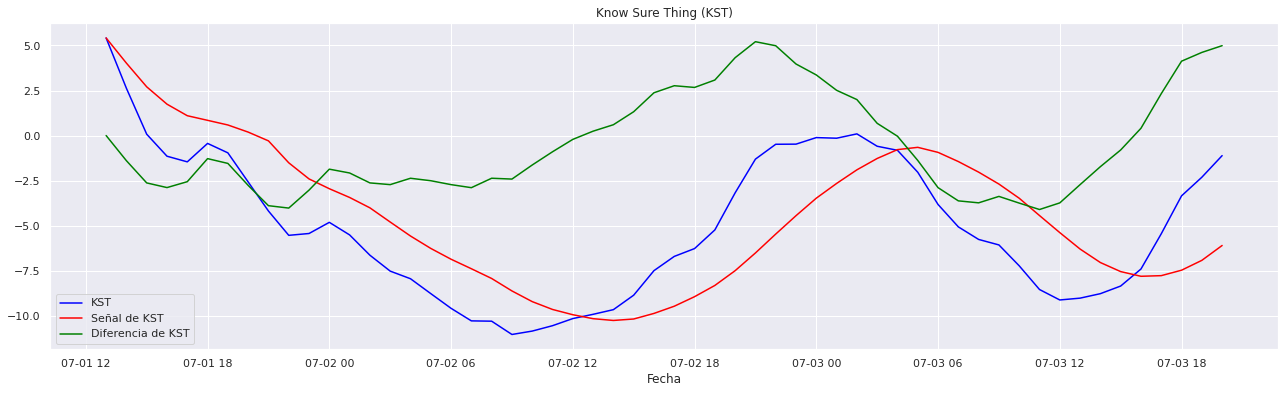

In [29]:
fig,axes = plt.subplots(1,1,figsize=(22,6))
axes.plot(df_ta.close_time, df_ta.trend_kst,color="blue")
axes.plot(df_ta.close_time, df_ta.trend_kst_sig,color="red")
axes.plot(df_ta.close_time, df_ta.trend_kst_diff,color="green")
axes.legend(["KST", "Señal de KST", "Diferencia de KST"])
#axes.set_ylabel("Precio (U$S)")
axes.set_xlabel("Fecha")
axes.set_title(f"Know Sure Thing (KST)");

#### Ichimoku Kinkō Hyō

Fuente: [Artículo de Ichimoku Kinkō Hyō en Wikipedia](https://en.wikipedia.org/wiki/Ichimoku_Kink%C5%8D_Hy%C5%8D)

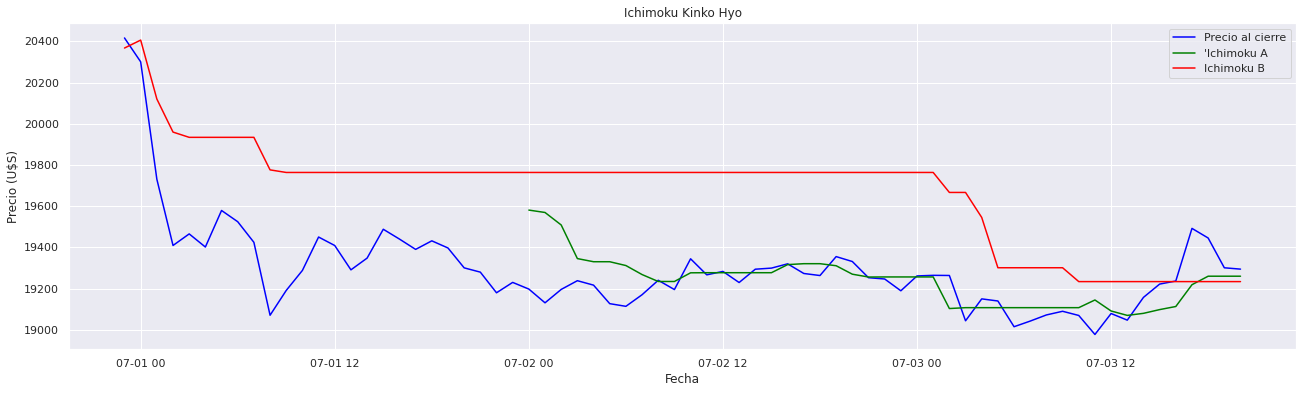

In [30]:
fig,axes = plt.subplots(1,1,figsize=(22,6))
axes.plot(df_ta.close_time, df_ta.Close,color="blue")
axes.plot(df_ta.close_time, df_ta.trend_ichimoku_a,color="green")
axes.plot(df_ta.close_time, df_ta.trend_ichimoku_b,color="red")
axes.legend(["Precio al cierre", "'Ichimoku A", "Ichimoku B"])
axes.set_ylabel("Precio (U$S)")
axes.set_xlabel("Fecha")
axes.set_title("Ichimoku Kinko Hyo");